## The Variance of Absorption Spectra

From discussing the mechanics of absorption spectra, it was clear that absorption lines themselves do not have a constant magnitude for all temperatures and pressures. This section uses an approximate global atmosphere model to reproduce the environment at different altitudes. 

The nature of climate models is that they have many interlinked parameters. These relationships must be modelled when the goal is to produce the most accurate model possible. However, this project's scope is to build a reasonable approximation for pedagogy. So by separating the variables and assessing their impact on the model, the most vital parts of the model can be retained.  

In [5]:
import os
import sqlite3
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dur_utils import colours
from scipy import constants
from scipy.integrate import simpson, quad

import isa

mpl.style.use("../CDS.mplstyle")

In [2]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, "w")

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


with HiddenPrints():
    pass

##  Standard Atmosphere Model
The "US Standard Atmosphere, 1976"{cite}`USAtmosphere` provides pressure, temperature, and density vertical profiles. The model takes values which are roughly representative of year-round mid-latitude conditions. The density profile is calculated using the temperature and pressure profiles through the ideal gas equation
```{math}
pV = n K_b T.
```
Where, $p$ is pressure, $V$ volume and $T$ temperature, n gives the number density of the gas and $K_b$ is Boltzmann's constant.

An approximate atmospheric profile is used to calculate molecule concentrations and cross-section broadening. A reasonable assumption in the troposphere is that the relative fractional abundances stay the same. Thus the decrease in atmospheric density provides the main trail off for total absorption. However, the constant relative fraction of greenhouse gases assumption breaks down, particularly for water and ozone fractional abundances above the 10km mark. This is because water forms clouds and precipitates down, becoming much less abundant, and ozone is produced more rapidly at higher altitudes and its concentration peaks in the stratosphere.

Despite falling density and pressure, there is an increase in temperature after $20 km$. This temperature increase is due primarily to Ozone absorbing Shortwave UV-radiation, which is incoming from the sun. This temperature increase is not accounted for in our model as we look at longwave radiation exiting the atmosphere.



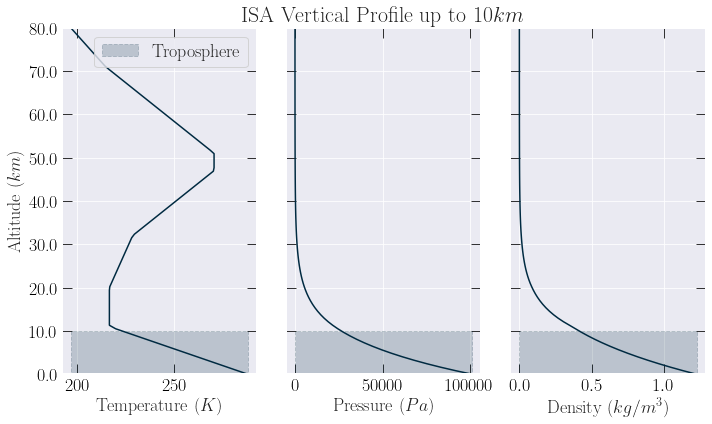

In [3]:
atlittudes = np.linspace(0, 80000, 100)
temp = isa.get_temperature(atlittudes)
pressure = isa.get_pressure(atlittudes)
density = isa.get_density(atlittudes)
fig, ax = plt.subplots(1, 3, figsize=(10, 6), sharey=True)
labels = ["Temperature $(K)$", "Pressure $(Pa)$", "Density $(kg/m^3)$"]
for i, profile in enumerate([temp, pressure, density]):
    ax[i].plot(profile, atlittudes, color=colours.durham.ink)
    ax[i].fill_between(
        [np.min(profile), np.max(profile)],
        [0, 0],
        [10**4, 10**4],
        linestyle="--",
        color=colours.durham.ink,
        label="Troposphere",
        alpha=0.2,
    )
    ax[i].set_yticks(ax[i].get_yticks(), ax[i].get_yticks() / 1000)
    ax[i].set_ylim(0, 80000)
    ax[i].set_xlabel(labels[i])
ax[0].set_ylabel("Altitude $(km)$")
ax[1].set_title("ISA Vertical Profile up to $10km$")
ax[0].legend()

## The Variation of the Absorbtion Cross-section of $\textrm{CO}_2$

The HITRAN Database provides the line-by-line intensities for more than 55 molecules. Using the IPCC reports data on the most potent greenhouse gases, the most impactful 3, $\textrm{CO}_2$, $\textrm{N}_2 \textrm{O}$, and $\textrm{CH}_4$. Additionally, water plays a significant role in the greenhouse effect. However, the variance in its concentration due to anthropogenic factors does not significantly drive global temperature rise. However, it does provide a large amount of radiation scattering and should be included{cite}`IPCCAR6`. 

Further, the changes in $\textrm{CO}_2$'s absorption profile can be used as a litmus test for simplifying assumptions and observing the effects of broadening and gas rarefaction. 
Additionally, to temperature and pressure dependence on the broadening, there is a further temperature dependence on the line intensity due to the accessibility of a given transition. At low temperatures, high-energy transitions, those of low wavelength, are heavily suppressed as the molecules lack the energy to access either the excitation or vibrational mode. A Bose-Einstein distribution quantifies the availability of a transition. When the intensity of a transition is known for one temperature, the ratio of the probabilities gives the intensity
```{math}
:label: S_{a \rightarrow b}(T) = S_{a \rightarrow b, T_ref}\frac{\exp(-h\nu_{a \rightarrow b} /cK_bT)}{exp(-h\nu_{a \rightarrow b} /cK_b T_{ref})} \frac(T_{ref}}{(T)}
```
Where $S_{a \rightarrow b}(T)$ is the line intensity as a function of temperature for some transition $a \rightarrow b$, $\nu_{a \rightarrow b}$ is the wavenumber for the transition, and $Q(T)$ is the partition sum over all states. The values for $S_{a \rightarrow b}(T_{ref})$ are recorded on the HITRAN database. $\textrm{CO}_2$'s line intensity variation is plotted at 3 km intervals up to 10km using the ISA model, around the most significant absorption lines, around $650 cm^{-1}$.

In [32]:
def number_density(alt):
    """
    Returns Number of particles per m^3
    assuming ideal gas.

    Args:
        alt (float): Altitude in meters.

    Returns:
        float: n(alt) in molecules/m^3
    """
    mass_of_air = (
        28.9647 * 10**-3 / constants.N_A
    )  # conver kg/m^3 to molecule/m^3
    return isa.get_density(alt) / mass_of_air


def particle_per_sq_m(alt_0, alt_1):
    """
    returns number of particles per square meter
    between two altitudes

    Args:
        alt_0 (float): altitude in meters
        alt_1 (float): altitude in meters

    Returns:
        float:
    """
    return quad(number_density, alt_0, alt_1)[0]


def optical_depth(alt_0, alt_1, ppm_conc, abs_coef):
    particles = particle_per_sq_m(alt_0, alt_1) * ppm_conc * 10 ** (-9)
    return (
        particles * abs_coef * 10 ** (-4)
    )  # 10^-4 factor from cm^2->m^2 conv

In [37]:
# SQL query
path = "../absorption_coef_database_utitlites/optical_depth.db"
conn = sqlite3.connect(path)
sql_query = "SELECT * FROM optical_depths WHERE mol_id = 2"
co2_optical_depth = pd.read_sql_query(sql_query, conn)
sql_query = "SELECT * FROM gases"
gases = pd.read_sql_query(sql_query, conn)
alts = co2_optical_depth["altitude"].unique();

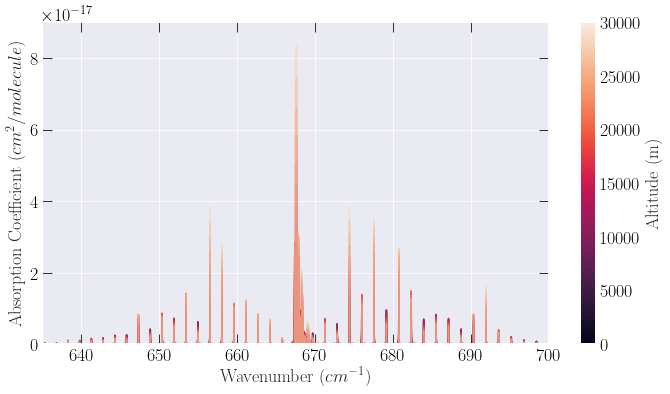

In [45]:
# Initialise Outputs
cmap = sns.color_palette("rocket", 10)
sm = plt.cm.ScalarMappable(
    cmap="rocket", norm=plt.Normalize(vmin=0, vmax=30000)
)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
color_cycle = ax.set_prop_cycle(color=cmap)
for alt in alts:
    mask = co2_optical_depth["altitude"] == alt
    abs_coef = co2_optical_depth[mask]["abs_coef"]
    nu = co2_optical_depth[mask]["wave_no"]
    plot = ax.plot(nu, abs_coef, alpha=0.4)

cb = fig.colorbar(sm)
cb.set_label("Altitude (m)")
ax.set_xlim(635, 700)
ax.set_ylim(0, 9 * 10**-17)
ax.set_xlabel("Wavenumber $(cm^{-1})$")
ax.set_ylabel("Absorption Coefficient $(cm^2/molecule)$")

## Optical Density of $\textrm{CO}_2$
The absorption coefficient,$k$, is related to the optical depth at a wavenumber,$\nu$, by
```{math}
\tau(\nu, \Delta l, T, p) = \int_{l}^{l+\Delta l} n(z) dz \cdot k(\nu, T, p).
```
Where n(z) is the number density per unit volume. Then we plot the optical depth, $I/I_0$, of each atmosphere block up to $30km$.

## Increasing Altitude's effect on Absorption

As the Greenhouse Gas molecules become more rarefied, the amount of radiation they absorb decreases. Further, when calculating the fraction of flux absorbed, the most computationally intensive part is the calculation of line-by-line absorption cross-sections. Therefore, if the contribution from the broadening does not provide a significant decrease in flux, an Assumption could be made that cross-section broadening was not necessary. However, we show below that broadening significantly reduces the atmosphere's opacity. 

The figure below plots the ratio of spectral radiance transmitted over the outgoing longwave wavenumber spectrum. The lines are filled between their values and one, such that if no radiance is let through in a region $\Delta \nu$, it will be opaque. The colour bar shows the colour gradient associated with increasing altitude. The dark outlines around the pale areas indicate that temperature and pressure broadening with increased altitude corresponds to a narrowing. This effect can also be seen above plot of the absorption coefficient.

In [51]:
od = []
flux_ratios = []
for alt in alts:
    mask = co2_optical_depth["altitude"] == alt
    alt_od = co2_optical_depth["optical_depth"][mask]
    od.append(alt_od)
    flux_ratios.append(np.exp(-alt_od/1000))

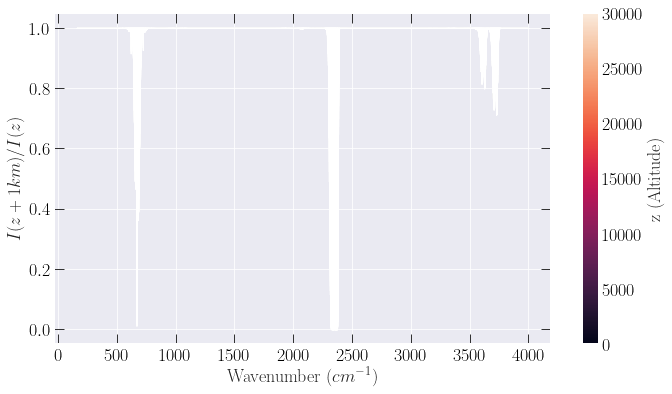

In [53]:
cmap = sns.color_palette("rocket", 10)
sm = plt.cm.ScalarMappable(
    cmap="rocket", norm=plt.Normalize(vmin=0, vmax=30000)
)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
color_cycle = ax.set_prop_cycle(color=cmap)
for flux_ratio in flux_ratios:
    plt.fill_between(nu, flux_ratio, 1)
cb = fig.colorbar(sm)
ax.set_xlabel("Wavenumber $(cm^{-1})$")
ax.set_ylabel("$I(z+1km)/I(z)$")
cb.set_label("z (Altitude)")

## Logarithmic Plot of Optical Depth, $\tau$

The previous figure displays clear windows of opacity which decrease in size with increasing altitude. Plotting a semilog plot of the optical depth $\tau$ shows the large range for which absorption coefficients can meaningfully impact flux transmitted through a block of atmosphere.

 $\tau$ values that appear to contribute, by eye, span a range $[10^{-1}, 10^5]$. The range is raised because typical efforts to reduce the amount of computation, such as an absolute value cut off of the form `values[values< max_value*0.001] = 0`, would produce severe discrepancies in the output of the previous figure.

A common technique used in radiation codes is to smooth the absorption lines and define windows of no absorption to reduce the computational cost. 

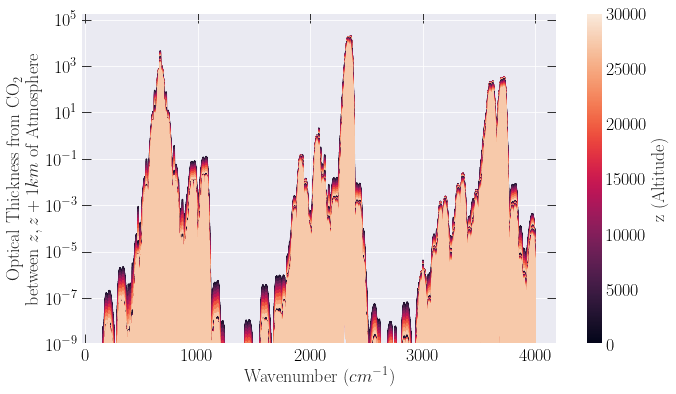

In [47]:

cmap = sns.color_palette('rocket', 10)
sm = plt.cm.ScalarMappable(cmap='rocket',
                           norm=plt.Normalize(vmin=0, vmax=30000)
                           )
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
color_cycle = ax.set_prop_cycle(color=cmap)

for o_d in od:
    ax.semilogy(nu, o_d)
cb = fig.colorbar(sm)
ax.set_xlabel('Wavenumber $(cm^{-1})$')
ax.set_ylabel(
    'Optical Thickness from CO$_2$ \n  between $z, z+1km$ of Atmosphere')
ax.set_ylim(10 ** -9)
cb.set_label('z (Altitude)')


In [ ]:
particle_per_sq_m(1000, 2000)

: 

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(nu, flux_ratios[0][0], linewidth=0.1)
plt.xlabel('wavenumber $cm^{-1}$')
plt.ylabel('Transmittance')

: 

: 